---
title: Sensitivity Analysis
subtitle: NIGnets Parameter Perturbation for Random Shape Generation
date: 2025-03-03
---

We now take a look at NIGnet sensitivity analysis. We add Gaussian noise to the NIGnet weight
matrices and generate shapes from the resulting noisy networks.

In [2]:
# Basic imports
import torch
from torch import nn
import geosimilarity as gs
from NIGnets import NIGnet
from NIGnets.monotonic_nets import SmoothMinMaxNet

from assets.utils import automate_training, plot_curves

We will perform sensitivity analysis for a NIGnet that is fit to an airfoil shape. Therefore, we
first fit a NIGnet to an airfoil.

Epoch: [    1/10000]. Loss:    0.542679
Epoch: [ 2000/10000]. Loss:    0.000147
Epoch: [ 4000/10000]. Loss:    0.000072
Epoch: [ 6000/10000]. Loss:    0.000054
Epoch: [ 8000/10000]. Loss:    0.000038
Epoch: [10000/10000]. Loss:    0.000024


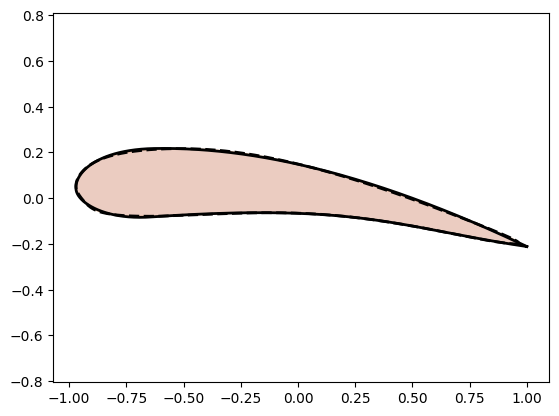

In [4]:
from assets.shapes import airfoil

# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
Xt = airfoil(num_pts)

nig_net = NIGnet(layer_count = 4, act_fn = nn.Tanh)

automate_training(
    model = nig_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = Xt,
    learning_rate = 0.1, epochs = 10000, print_cost_every = 2000
)

Xc = nig_net(t)
plot_curves(Xc, Xt)

Now we use the `generate_noisy_shapes()` method to produce shapes from NIGnets produced by
perturbing the weight matrices with Gaussian noise of specified standard deviation.

Every shape is produced by perturbing each weight matrix of the network as follows:
:::{code} python
noisy_net = copy.deepcopy(self)
for param in noisy_net.parameters():
    param.data += torch.randn_like(param) * noise_amount
:::

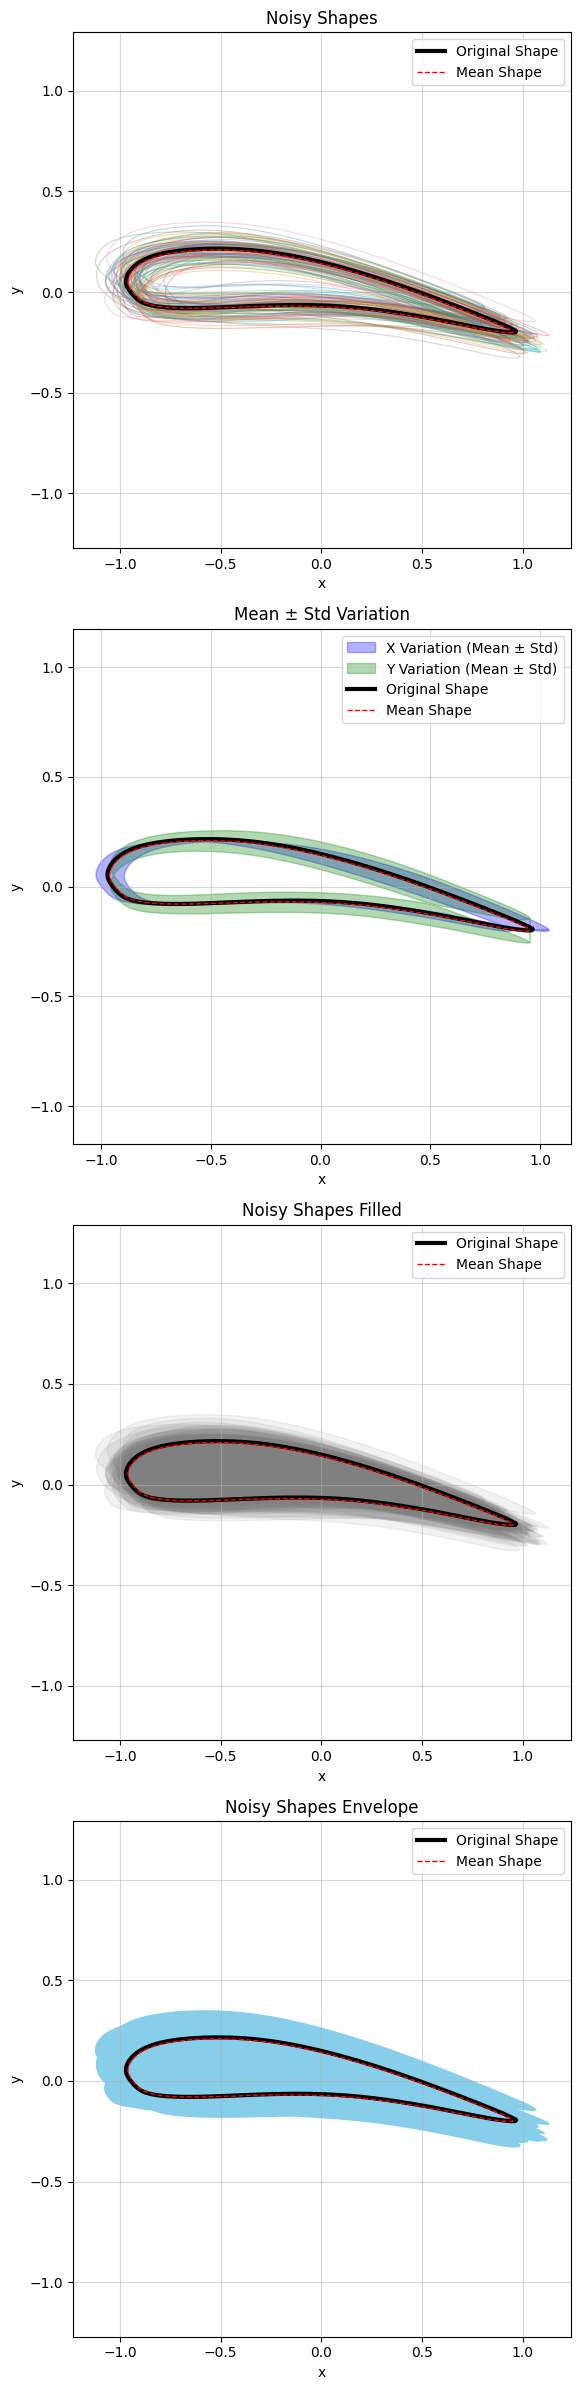

In [ ]:
nig_net.generate_noisy_shapes(
    noise_amount = 0.02,
    num_generations = 100,
    num_pts = 1000
)

## Interesting Observation
Notice that the mean airfoil shape (shown by the red dashed curve in the above figures) lies almost
on top of the original airfoil. This has a great implication on the usefulness of NIGnets.

In particular, let's say you had an airfoil shape and you wanted to create more shapes from it to
create some sort of 'airfoil-like' database. Then one way to do so would be to add noise directly to
the airfoil coordinates, but that would cause the generated shape to not be smooth. This is shown
below:

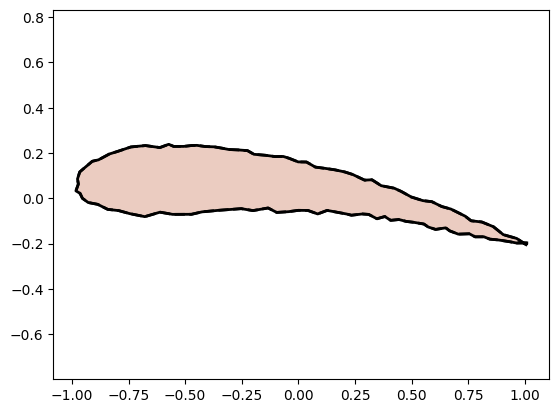

In [12]:
from assets.shapes import airfoil

# Generate target curve points
num_pts = 100
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
Xt = airfoil(num_pts)

noise_amount = 0.02
Xc = Xt + torch.rand_like(Xt) * noise_amount
plot_curves(Xc, Xc)

If you create a 1000 such airfoils and find the mean shape it would approximately be the original
airfoil shape, but each individual airfoil as shown above lacks smoothness properties.

Using NIGnets, one can create smooth perturbations of the original airfoil and the mean shape would
still approximately be the original shape as was shown in the figures plotted above!

Essentially what we do is create perturbed copies of the original shape network (not the shape
itself). Now since each network is smooth, the shapes that each network represents are also smooth!
And since, the mean of the shapes represented by the perturbed networks is the original airfoil
shape, we are able to create smooth perturbations of the airfoil the mean of which is still the
original shape.